In [2]:
library(ggplot2)
library(Seurat)
library(harmony)
library(ggsci)
library(RColorBrewer)
library(reshape2)
library(patchwork)
#library(harmony)
library(dplyr)
#library(GGally)
library(Matrix)
#library(sf)
library(data.table)
library(RANN)
#Sys.setenv(PROJ_LIB = "/opt/conda/share/proj")
library(igraph)
#library(ggpubr)
library(readxl)
library(tidyr)
library(RColorBrewer)
library(ClusterFoldSimilarity)
library(pheatmap)
library(scatterpie)
#library(ComplexHeatmap)
library(circlize)
library(UpSetR)

In [3]:
jaccard_similarity <- function(list1, list2) {
  set1 <- unique(list1)
  set2 <- unique(list2)

  intersection <- intersect(set1, set2)
  union <- union(set1, set2)

  similarity <- length(intersection) / length(union)

  return(similarity)
}

In [4]:
Archr_col <- c('#D51F26','#272E6A','#208A42','#89288F','#F47D2B','#FEE500','#8A9FD1',
               '#C06CAB','#E6C2DC','#90D5E4','#89C75F','#F37B7D','#9983BD','#D24B27',
               '#3BBCA8','#6E4B9E','#0C727C','#7E1416','#D8A767')

In [7]:
mar <- readRDS('data/marmoset_VL_gene_new.rds')
mac <- readRDS('data/macaque_VL_gene_new.rds')
human <- readRDS('data/human_VL_gene.rds')

In [5]:
orth <- as.data.frame(fread("data/mart_export.humanMacaqeMarmosetMouse.oneToOneOrth.ensembl91.20220428.txt"))

# Get region-enriched genes

In [10]:
mar <- NormalizeData(mar,verbose = F)
mac <- NormalizeData(mac,verbose = F)
human <- NormalizeData(human,verbose = F)

In [13]:
VL_region <- human@meta.data[,'region']

In [24]:
human_df <- as.data.frame(human@assays$RNA@data)
mar_df <- as.data.frame(mar@assays$RNA@data)
mac_df <- as.data.frame(mac@assays$RNA@data)

In [6]:
# Function to calculate FC and FC_count for a given species
calculate_FC <- function(species_df, region, orth_df, species_gene_col) {
  # Initialize an empty data frame to store the results
  FC_df <- data.frame()
  
  # Loop through each gene in the species data frame
  for (i in 1:nrow(species_df)) {
    # Transpose the row of the species data frame
    df <- as.data.frame(t(species_df[i,]))
    # Set the column name of the transposed data frame
    colnames(df)[1] = 'Fraction'
    # Calculate the normalized value
    df$t0 <- (df$Fraction - min(df$Fraction)) / (max(df$Fraction) - min(df$Fraction)) + 1
    # Calculate the fold change
    df$FC <- df[region, 't0'] / df$t0
    # Calculate the mean fold change
    FC <- mean(df$FC)
    # Calculate the sum of counts for the gene
    sumcount <- sum(species_df[i,])
    # Calculate the fold change count
    FC_count <- FC * sumcount
    # Create a data frame with the gene name, fold change, and fold change count
    result <- data.frame('gene' = rownames(species_df)[i], 'FC' = FC, 'FC_count' = FC_count)
    # Append the result to the FC_df
    FC_df <- rbind(FC_df, result)
  }
  
  # Filter the FC_df to include only genes that are in the ortholog data frame
  orth_df_filtered <- FC_df[FC_df$gene %in% orth_df[[species_gene_col]], ]
  # Set the rownames of the ortholog data frame to the gene names
  rownames(orth_df) <- orth_df[[species_gene_col]]
  
  # Add columns for the other species' genes
  other_species <- setdiff(names(orth_df)[1:4], species_gene_col)
  for (species in other_species) {
    orth_df_filtered[[species]] <- orth_df[orth_df_filtered$gene, species]
  }
  
  return(orth_df_filtered)
}

# Function to process data for a given species
process_species <- function(species_df, region, orth_df, species_gene_col, output_dir) {
  # Create the output directory if it doesn't exist
  if (!dir.exists(output_dir)) {
    dir.create(output_dir)
  }
  
  # Loop through each region
  for (j in region) {
    # Calculate the FC and FC_count for the species
    mar_orth <- calculate_FC(species_df, j, orth_df, species_gene_col)
    # Write the results to a CSV file
    write.csv(mar_orth, paste0(output_dir, "/", j, "_gene.csv"), quote = FALSE)
  }
}



In [ ]:
process_species(mar_df, VL_region, orth, "marmosetGene", "data/mar_VL")

In [ ]:
# Process human data
process_species(human_df, VL_region, orth, "humanGene", "data/human_VL")
# Process marmoset data
process_species(mar_df, VL_region, orth, "marmosetGene", "data/mar_VL")
# Process macaque data
process_species(mac_df, VL_region, orth, "macaqueGene", "data/mac_VL")

# get Pr-shared & Al-shared Genes

In [66]:
# Load data from RDS files
mar <- readRDS('data/marmoset.rds')
human <- readRDS('data/human.rds')
mac <- readRDS('data/macaque.rds')

# Set thresholds
thed <- 0
pthed <- 2

# Function to get genes based on p.value and GEI thresholds
get_genes_by_threshold <- function(data, thed, pthed) {
  pr <- rownames(data@assays$RNA@meta.features[data@assays$RNA@meta.features$p.value < pthed & (data@assays$RNA@meta.features$GEI < -thed), ])
  al <- rownames(data@assays$RNA@meta.features[data@assays$RNA@meta.features$p.value < pthed & (data@assays$RNA@meta.features$GEI > thed), ])
  return(list(pr = pr, al = al))
}

# Get genes for each species

In [67]:
human_genes <- get_genes_by_threshold(human, thed, pthed)
mac_genes <- get_genes_by_threshold(mac, thed, pthed)
mar_genes <- get_genes_by_threshold(mar, thed, pthed)

human_gene <- rownames(human)
mac_gene <- rownames(mac)
mar_gene <- rownames(mar)

# Function to intersect genes with orthologs and convert to marmoset genes
convert_to_marmoset_genes <- function(genes, orth, gene_col) {
  rownames(orth) <- orth[[gene_col]]
  genes <- intersect(genes, orth[[gene_col]])
  return(orth[genes, 'marmosetGene'])
}

# Convert genes to marmoset genes
human_gene <- convert_to_marmoset_genes(human_gene, orth, "humanGene")
mac_gene <- convert_to_marmoset_genes(mac_gene, orth, "macaqueGene")
mar_gene <- intersect(orth$marmosetGene, mar_gene)

# Find common genes
com_gene <- intersect(intersect(human_gene, mac_gene), mar_gene)

# Function to intersect and convert genes
process_genes <- function(genes, orth, gene_col, com_gene) {
  genes <- intersect(orth$marmosetGene, genes)
  rownames(orth) <- orth[[gene_col]]
  genes <- orth[genes, 'marmosetGene']
  return(intersect(genes, com_gene))
}

# Process PR and AL genes for each species
human_pr <- process_genes(human_genes$pr, orth, "humanGene", com_gene)
human_al <- process_genes(human_genes$al, orth, "humanGene", com_gene)
mac_pr <- process_genes(mac_genes$pr, orth, "macaqueGene", com_gene)
mac_al <- process_genes(mac_genes$al, orth, "macaqueGene", com_gene)
mar_pr <- process_genes(mar_genes$pr, orth, "marmosetGene", com_gene)
mar_al <- process_genes(mar_genes$al, orth, "marmosetGene", com_gene)

# Create a list of gene sets
listInput <- list(hum_Pr = human_pr, mac_Pr = mac_pr, mar_Pr = mar_pr, hum_Al = human_al, mac_Al = mac_al, mar_Al = mar_al)

# Function to convert upset data to intersections
upset2inter <- function(upset_data) {
  intersection <- lapply(1:nrow(upset_data), function(X) {
    tmp <- upset_data[X, ]
    intersection <- sort(colnames(tmp)[tmp != 0])
    intersection <- paste(intersection, collapse = "/")
    return(intersection)
  })
  intersection <- as.data.frame(cbind(rownames(upset_data), intersection))
  colnames(intersection) <- c("V1", "intersection")
  intersection$V1 <- as.character(intersection$V1)
  intersection$intersection <- as.character(intersection$intersection)
  return(intersection)
}

# Process upset data
upset_data <- dplyr::bind_rows(lapply(names(listInput), function(x) {
  df <- data.frame(gene = listInput[[x]])
  type <- gsub('human', 'hum', x)
  df$type <- paste0(strsplit(type, '_')[[1]][2], '_', strsplit(type, '_')[[1]][1])
  df$num <- 1
  return(df)
}))
upset_data <- acast(upset_data, gene ~ type, value.var = "num")
upset_data[is.na(upset_data)] <- 0
upset_data <- as.data.frame.array(upset_data)
Pr_Al_inter <- upset2inter(upset_data)
rownames(Pr_Al_inter) <- Pr_Al_inter$V1




In [8]:
# Function to read DEG data
read_DEG <- function(path, species, use_gene) {
  files <- list.files(path)
  df_list <- dplyr::bind_rows(lapply(files, function(x) {
    df <- read.csv(paste0(path, '/', x))
    region <- gsub('_gene.csv|mac_|mar_|human_', '', x)
    df$region <- region
    df$species <- species
    df <- df[df$gene %in% use_gene, ]
    df <- df[, c('gene', 'FC', 'species', 'region')]
    # df$intersect <- Pr_Al_inter[df$gene, 'intersection']
    return(df)
  }))
  return(df_list)
}

# Function to calculate region DEG intersections
region_DEG_intersect <- function(tmp_region) {
  tmp_data <- rbind(
    DEG_mac[DEG_mac$FC > 1 & DEG_mac$region == tmp_region, ],
    DEG_mar[DEG_mar$FC > 1 & DEG_mar$region == tmp_region, ],
    DEG_hum[DEG_hum$FC > 1 & DEG_hum$region == tmp_region, ]
  )
  tmp_data$num <- 1
  tmp_data <- acast(tmp_data, gene ~ species, value.var = "num")
  tmp_data[is.na(tmp_data)] <- 0
  tmp_data <- as.data.frame.array(tmp_data)
  tmp_data <- upset2inter(tmp_data)
  tmp_data$Pr_Al <- Pr_Al_inter[tmp_data$V1, 'intersection']
  return(tmp_data)
}


In [48]:
# Read DEG data for each species
DEG_hum <- read_DEG('data/human_VL/', 'hum', Pr_Al_inter[Pr_Al_inter$intersection %in% c('Al_hum/Al_mac/Al_mar', 'Pr_hum/Pr_mac/Pr_mar'), ]$V1)
DEG_mac <- read_DEG('data/mac_VL/', 'mac', Pr_Al_inter[Pr_Al_inter$intersection %in% c('Al_hum/Al_mac/Al_mar', 'Pr_hum/Pr_mac/Pr_mar'), ]$V1)
DEG_mar <- read_DEG('data/mar_VL/', 'mar', Pr_Al_inter[Pr_Al_inter$intersection %in% c('Al_hum/Al_mac/Al_mar', 'Pr_hum/Pr_mac/Pr_mar'), ]$V1)

In [56]:
# Define a vector of VL regions
VL_list <- VL_region

# Apply the region_DEG_intersect function to each region in VL_list
# For each region, calculate the upset data and convert it to a frequency table
# Add the region name as a new column and return the data frame
inter_list <- lapply(VL_list, function(tmp_region) {
    # Calculate the upset data for the current region
    upset_data <- region_DEG_intersect(tmp_region)
    # Create a frequency table of the intersections and Pr_Al values
    upset_data <- as.data.frame(table(upset_data$intersection, upset_data$Pr_Al))
    # Add the region name as a new column
    upset_data$region <- tmp_region
    return(upset_data)
})

# Combine all data frames in inter_list into a single data frame
inter_df <- dplyr::bind_rows(inter_list)

# Calculate the total frequency for each region
region_sum <- aggregate(Freq ~ region, data = inter_df, sum)
# Set the row names of region_sum to the region names
rownames(region_sum) <- region_sum$region

# Calculate the total frequency for each combination of species and region
species_region_sum <- aggregate(Freq ~ Var1 + region, data = inter_df, sum)
# Set the row names of species_region_sum to a combination of species and region
rownames(species_region_sum) <- paste0(species_region_sum$Var1, '_', species_region_sum$region)
# Calculate the proportion of each combination relative to the total frequency of the region
species_region_sum$prop <- species_region_sum$Freq / region_sum[species_region_sum$region, 'Freq']

# Reshape the data frame to a wide format for plotting
plot_pie <- as.data.frame(acast(inter_df, Var1 + region ~ Var2, value.var = "Freq"))
# Extract the species name from the row names
plot_pie$species <- sapply(rownames(plot_pie), function(x) { return(strsplit(x, '_')[[1]][1]) })
# Extract the region name from the row names
plot_pie$region <- sapply(rownames(plot_pie), function(x) { return(strsplit(x, '_')[[1]][2]) })
# Add the proportion and frequency columns from species_region_sum
plot_pie$prop <- species_region_sum[rownames(plot_pie), 'prop']
plot_pie$Freq <- species_region_sum[rownames(plot_pie), 'Freq']
# Reorder the columns for better readability
plot_pie <- plot_pie[, c('species', 'region', 'prop', 'Freq', as.character(unique(inter_df$Var2)))]

# Define the X-axis values and labels
X_axis <- 1:7
names(X_axis) <- rev(c('hum/mac/mar', 'hum', 'mac', 'mar', 'hum/mac', 'mac/mar', 'hum/mar'))
# Define the Y-axis values and labels
Y_axis <- 1:15
names(Y_axis) <- rev(c('SS', 'AU', 'RSC', 'MPFC', 'DLPFC', 'VLPFC', 'OFC', 'VT', 'ACC', 'LS', 'MOT', 'PCC', 'PPC', 'LIT', 'VC'))

# Add X-axis and Y-axis values to the plot_pie data frame
plot_pie$X_axis <- X_axis[plot_pie$species]
plot_pie$Y_axis <- Y_axis[plot_pie$region]

Warning message in geom_arc_bar(mapping, data = df, stat = "pie", inherit.aes = FALSE, :
“Ignoring unknown parameters: `linewidth`”


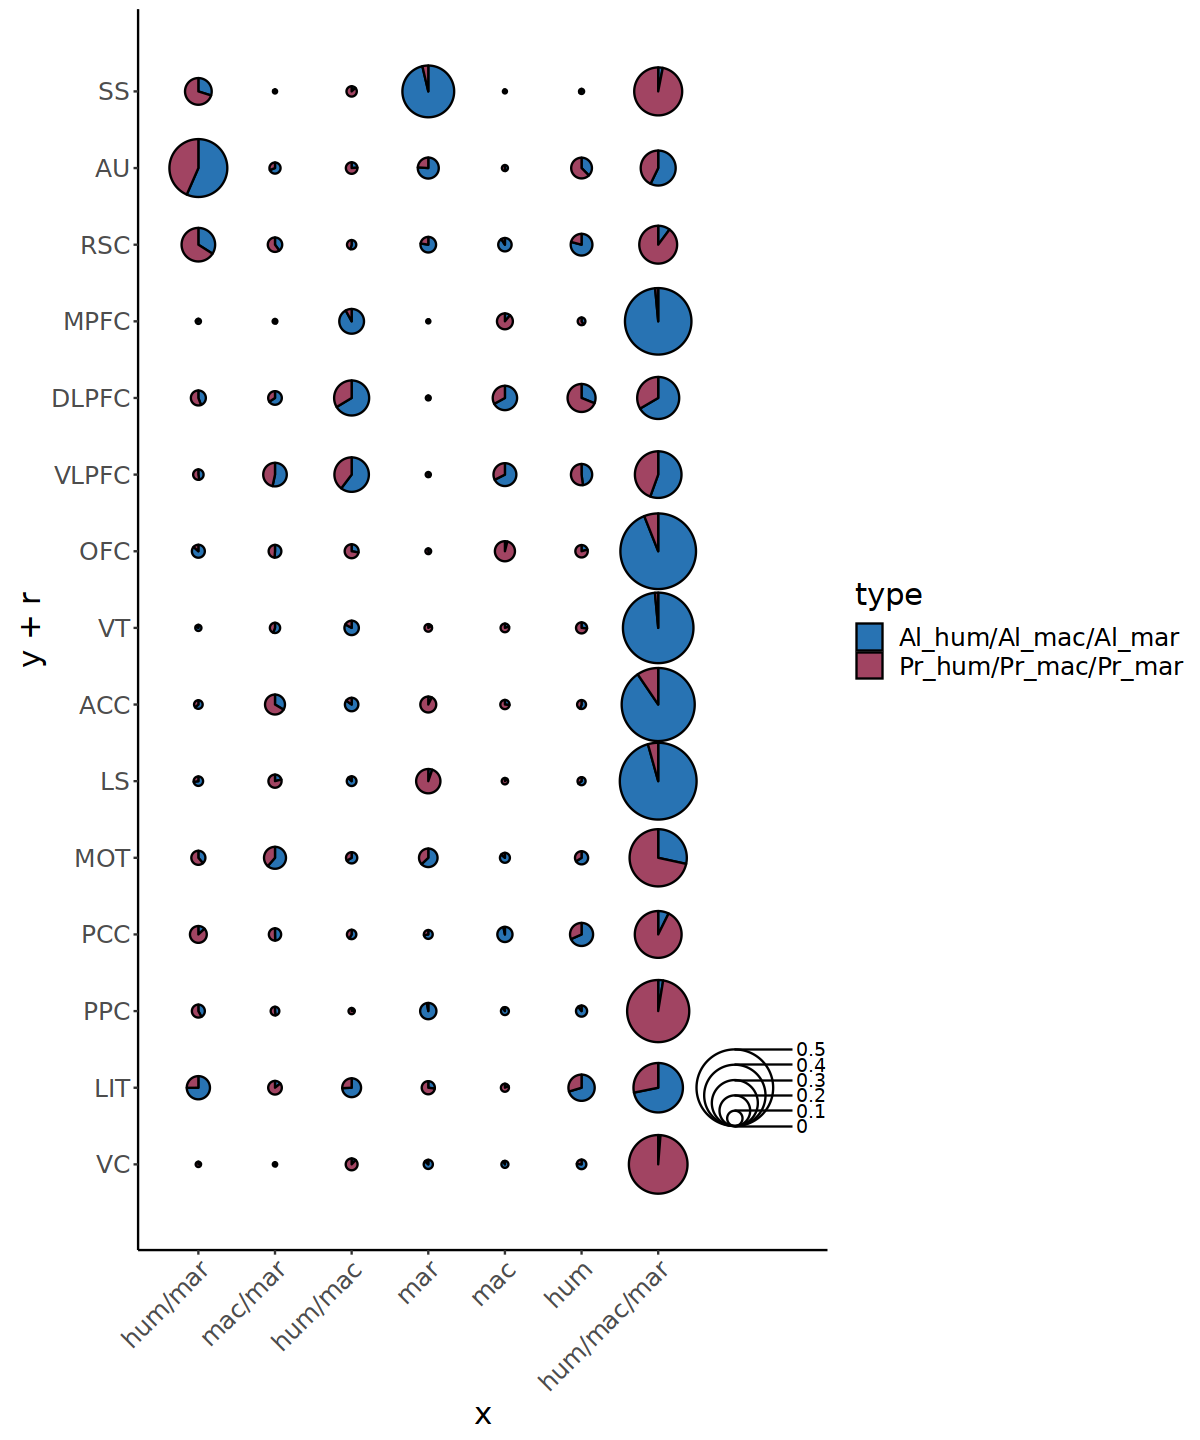

In [63]:
options(repr.plot.width=10,repr.plot.height=12)
p1 <- ggplot() +
geom_scatterpie(aes(x = X_axis, y = Y_axis,r=.0004 *Freq),color='black',linewidth=0.2,
                data = plot_pie, cols = c('Al_hum/Al_mac/Al_mar','Pr_hum/Pr_mac/Pr_mar'))+
scale_fill_manual(values = c("#2873B3","#A14462",
                             'gray','gray',
                             #'#00A087FF','#F39B7FFF',
                             'gray','gray','gray','gray')) +
scale_y_continuous(breaks = Y_axis,labels = names(Y_axis)) +
scale_x_continuous(breaks = X_axis,labels = names(X_axis)) +
theme_classic()+
coord_fixed()+
theme(text = element_text(size=18,color='black'),axis.text.x = element_text(angle=45,vjust=1,hjust=1))+ 
geom_scatterpie_legend(.0004 *plot_pie$Freq, x=8, y=2)
p1

# AU sub-region genes

In [78]:
# ... existing code ...

# Read data from RDS and CSV files
# Read marmoset, macaque, and human data from RDS files
mar <- readRDS('data/marmoset_gene_new.rds')
mac <- readRDS('data/macaque_gene_new.rds')
human <- readRDS('data/human_addmodule.rds')

# Read VL data from CSV files
mar_VL <- read.csv('/data/work/mar_VL.csv', row.names = 1)
mac_VL <- read.csv('/data/work/mac_VL.csv', row.names = 1)
hum_VL <- read.csv('/data/work/human_VL.csv', row.names = 1)

# Add VL data to the corresponding objects
mar$VL <- mar_VL[mar$region, 'VL']
mac$VL <- mac_VL[mac$region, 'VL']
human$VL <- hum_VL[human$region, 'VL']

# Normalize the data
mar <- NormalizeData(mar)
mac <- NormalizeData(mac)
human <- NormalizeData(human)

# Convert the data to data frames
human_df <- as.data.frame(human@assays$RNA@data)
mar_df <- as.data.frame(mar@assays$RNA@data)
mac_df <- as.data.frame(mac@assays$RNA@data)

# Define region columns for each species
# Marmoset region columns
core <- c('AuA1', 'AuR', 'AuRT')
belt_cols <- c('AuAL', 'AuCL', 'AuCM', 'AuML', 'AuRM', 'AuRTL', 'AuRTM')
parabelt_cols <- c('AuCPB', 'AuRPB')
other <- c('STR')

# Macaque region columns
mac_core <- c('AI', 'R', 'RT')
mac_belt <- c('AL', 'CL', 'CM', 'ML', 'RM', 'RTL', 'RTM')
mac_parabelt <- c('CPB', 'RPB')
mac_other <- c('STGr')

# Human region columns
human_other <- c('52', 'TA2', 'STGa', 'A5', 'STSdp', 'STSvp', 'A4', 'STSva')



In [ ]:
process_species(human_df,'A1', orth, "humanGene", "data/human_core")
process_species(mar_df, core, orth, "marmosetGene", "data/mar_core")
process_species(mac_df, mac_core, orth, "macaqueGene", "data/mac_core")

In [ ]:
# Calculate average expression for each region in marmoset data
mar_df$Core <- rowMeans(mar_df[, core])
mar_df$Belt <- rowMeans(mar_df[, belt_cols])
mar_df$ParaBelt <- rowMeans(mar_df[, parabelt_cols])
mar_df$Other <- mar_df[, other]

# Remove original region columns from marmoset data
mar_df <- mar_df[, !(names(mar_df) %in% c(core, belt_cols, parabelt_cols, other))]

# Calculate average expression for each region in macaque data
mac_df$Core <- rowMeans(mac_df[, mac_core])
mac_df$Belt <- rowMeans(mac_df[, mac_belt])
mac_df$ParaBelt <- rowMeans(mac_df[, mac_parabelt])
mac_df$Other <- mac_df[, mac_other]

# Remove original region columns from macaque data
mac_df <- mac_df[, !(names(mac_df) %in% c(mac_core, mac_belt, mac_parabelt, mac_other))]

# Calculate average expression for the 'Other' region in human data
human_df$Other <- rowMeans(human_df[, human_other])

# Remove original 'Other' region columns from human data
human_df <- human_df[, !(names(human_df) %in% c(human_other))]

# Define region names for each species
human_AU_region <- c('A1', 'MBelt', 'PBelt', 'Other')
mar_AU_region <- c('Core', 'Belt', 'ParaBelt', 'Other')
mac_AU_region <- c('Core', 'Belt', 'ParaBelt', 'Other')

In [96]:
process_species(human_df, human_AU_region, orth, "humanGene", "data/human_subregion")
process_species(mar_df, mar_AU_region, orth, "marmosetGene", "data/mar_subregion")
process_species(mac_df, mac_AU_region, orth, "macaqueGene", "data/mac_subregion")

In [9]:
orth_human  <- intersect(rownames(human),orth$humanGene)
orth_mar <- intersect(rownames(mar),orth$marmosetGene)
orth_mac <- intersect(rownames(mac),orth$macaqueGene)

rownames(orth) <- orth$humanGene
orth_human <- orth[orth_human,'marmosetGene']
rownames(orth) <- orth$macaqueGene
orth_mac <- orth[orth_mac,'marmosetGene']
com_gene = intersect(intersect(orth_human,orth_mar),orth_mac)

## Pr_shared Genes

In [74]:
DEG_hum_sub <- read_DEG('data/human_subregion/','hum',Pr_Al_inter[Pr_Al_inter$intersection %in% c( 'Pr_hum/Pr_mac/Pr_mar'), ]$V1)
DEG_mar_sub <- read_DEG('data/mar_subregion/','mar',Pr_Al_inter[Pr_Al_inter$intersection %in% c('Pr_hum/Pr_mac/Pr_mar'), ]$V1)
DEG_mac_sub <- read_DEG('data/mac_subregion/','mac',Pr_Al_inter[Pr_Al_inter$intersection %in% c('Pr_hum/Pr_mac/Pr_mar'), ]$V1)

In [75]:
tmp_data_sub <- rbind(DEG_hum_sub[DEG_hum_sub$FC>2**0,],
                      DEG_mar_sub[DEG_mar_sub$FC>2**0,],
                      DEG_mac_sub[DEG_mac_sub$FC>2**0,])
tmp_data_sub$num <- 1
tmp_data_sub <- acast(tmp_data_sub, gene~species+region, value.var="num")
tmp_data_sub[is.na(tmp_data_sub)] = 0


In [76]:
AU_sub_Jacarrd <- reshape2::melt(1-as.matrix(proxy::dist(tmp_data_sub, by_rows = FALSE, method = "Jaccard")))
AU_sub_Jacarrd$Var1 <- as.character(AU_sub_Jacarrd$Var1)
AU_sub_Jacarrd$Var2 <- as.character(AU_sub_Jacarrd$Var2)
AU_sub_Jacarrd <- AU_sub_Jacarrd[
               (AU_sub_Jacarrd$Var1=='hum_A1'&(AU_sub_Jacarrd$Var2=='mar_Core'|AU_sub_Jacarrd$Var2=='mac_Core'))|
               (AU_sub_Jacarrd$Var1=='hum_MBelt'&(AU_sub_Jacarrd$Var2=='mar_Belt'|AU_sub_Jacarrd$Var2=='mac_Belt'))|
               (AU_sub_Jacarrd$Var1=='hum_PBelt'&(AU_sub_Jacarrd$Var2=='mar_ParaBelt'|AU_sub_Jacarrd$Var2=='mac_ParaBelt'))|
               (AU_sub_Jacarrd$Var1=='hum_Other'&(AU_sub_Jacarrd$Var2=='mar_Other'|AU_sub_Jacarrd$Var2=='mac_Other')),]
AU_sub_Jacarrd$type <- sapply(AU_sub_Jacarrd$Var2,function(x){strsplit(x,'_')[[1]][2]})
AU_sub_Jacarrd$species <- sapply(AU_sub_Jacarrd$Var2,function(x){strsplit(x,'_')[[1]][1]})

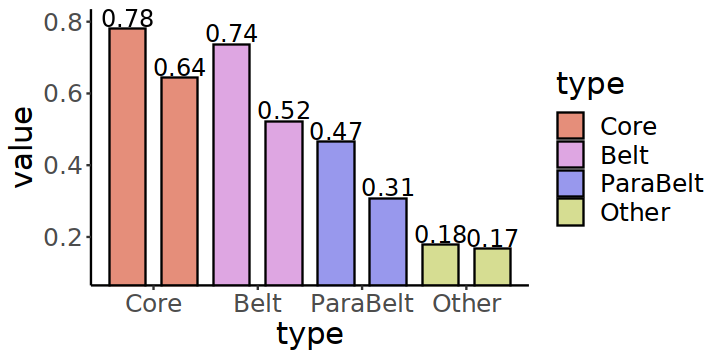

In [77]:
options(repr.plot.width=6,repr.plot.height=3)

AU_sub_Jacarrd$species <- factor(AU_sub_Jacarrd$species,levels = c('mar','mac'))
AU_sub_Jacarrd$type <- factor(AU_sub_Jacarrd$type,levels = c('Core','Belt','ParaBelt','Other'))

ggplot()+
geom_bar(data=AU_sub_Jacarrd,aes(x=type,y=value,fill=type,group=species),color='black',width=0.7,stat = 'identity',position=position_dodge(width = 1))+
geom_text(data=AU_sub_Jacarrd,aes(x=type,y=value+0.03,label=round(value,2),group=species),size=5,color='black',position=position_dodge(width = 1))+
scale_fill_manual(values = c('#E58E7A','#DEA6E2','#9898ED','#D6DD92'))+
theme_classic()+
theme(text = element_text(size=18,color='black'))+
coord_cartesian(ylim=c(0.1,0.8))

## Al-shared Genes

In [69]:
DEG_hum_sub <- read_DEG('data/human_subregion/','hum',Pr_Al_inter[Pr_Al_inter$intersection %in% c('Al_hum/Al_mac/Al_mar'), ]$V1)
DEG_mar_sub <- read_DEG('data/mar_subregion/','mar',Pr_Al_inter[Pr_Al_inter$intersection %in% c('Al_hum/Al_mac/Al_mar'), ]$V1)
DEG_mac_sub <- read_DEG('data/mac_subregion/','mac',Pr_Al_inter[Pr_Al_inter$intersection %in% c('Al_hum/Al_mac/Al_mar'), ]$V1)

In [70]:
tmp_data_sub <- rbind(DEG_hum_sub[DEG_hum_sub$FC>2**0,],
                      DEG_mar_sub[DEG_mar_sub$FC>2**0,],
                      DEG_mac_sub[DEG_mac_sub$FC>2**0,])
tmp_data_sub$num <- 1
tmp_data_sub <- acast(tmp_data_sub, gene~species+region, value.var="num")
tmp_data_sub[is.na(tmp_data_sub)] = 0


In [71]:
AU_sub_Jacarrd <- reshape2::melt(1-as.matrix(proxy::dist(tmp_data_sub, by_rows = FALSE, method = "Jaccard")))
AU_sub_Jacarrd$Var1 <- as.character(AU_sub_Jacarrd$Var1)
AU_sub_Jacarrd$Var2 <- as.character(AU_sub_Jacarrd$Var2)
AU_sub_Jacarrd <- AU_sub_Jacarrd[
               (AU_sub_Jacarrd$Var1=='hum_A1'&(AU_sub_Jacarrd$Var2=='mar_Core'|AU_sub_Jacarrd$Var2=='mac_Core'))|
               (AU_sub_Jacarrd$Var1=='hum_MBelt'&(AU_sub_Jacarrd$Var2=='mar_Belt'|AU_sub_Jacarrd$Var2=='mac_Belt'))|
               (AU_sub_Jacarrd$Var1=='hum_PBelt'&(AU_sub_Jacarrd$Var2=='mar_ParaBelt'|AU_sub_Jacarrd$Var2=='mac_ParaBelt'))|
               (AU_sub_Jacarrd$Var1=='hum_Other'&(AU_sub_Jacarrd$Var2=='mar_Other'|AU_sub_Jacarrd$Var2=='mac_Other')),]
AU_sub_Jacarrd$type <- sapply(AU_sub_Jacarrd$Var2,function(x){strsplit(x,'_')[[1]][2]})
AU_sub_Jacarrd$species <- sapply(AU_sub_Jacarrd$Var2,function(x){strsplit(x,'_')[[1]][1]})

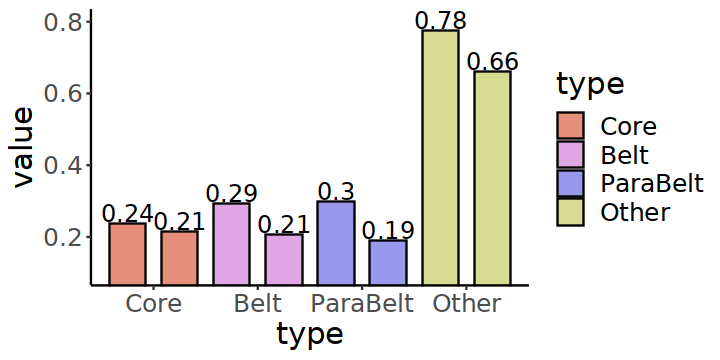

In [73]:
options(repr.plot.width=6,repr.plot.height=3)

AU_sub_Jacarrd$species <- factor(AU_sub_Jacarrd$species,levels = c('mar','mac'))
AU_sub_Jacarrd$type <- factor(AU_sub_Jacarrd$type,levels = c('Core','Belt','ParaBelt','Other'))

ggplot()+
geom_bar(data=AU_sub_Jacarrd,aes(x=type,y=value,fill=type,group=species),color='black',width=0.7,stat = 'identity',position=position_dodge(width = 1))+
geom_text(data=AU_sub_Jacarrd,aes(x=type,y=value+0.03,label=round(value,2),group=species),size=5,color='black',position=position_dodge(width = 1))+
scale_fill_manual(values = c('#E58E7A','#DEA6E2','#9898ED','#D6DD92'))+
theme_classic()+
theme(text = element_text(size=18,color='black'))+
coord_cartesian(ylim=c(0.1,0.8))

## ALL Genes

In [80]:
DEG_hum_sub <- read_DEG('data/human_subregion/','hum',com_gene)
DEG_mar_sub <- read_DEG('data/mar_subregion/','mar',com_gene)
DEG_mac_sub <- read_DEG('data/mac_subregion/','mac',com_gene)

In [25]:
tmp_data_sub <- rbind(DEG_hum_sub[DEG_hum_sub$FC>2**0,],
                      DEG_mar_sub[DEG_mar_sub$FC>2**0,],
                      DEG_mac_sub[DEG_mac_sub$FC>2**0,])
tmp_data_sub$num <- 1
tmp_data_sub <- acast(tmp_data_sub, gene~species+region, value.var="num")
tmp_data_sub[is.na(tmp_data_sub)] = 0


In [63]:
AU_sub_Jacarrd <- reshape2::melt(1-as.matrix(proxy::dist(tmp_data_sub, by_rows = FALSE, method = "Jaccard")))
AU_sub_Jacarrd$Var1 <- as.character(AU_sub_Jacarrd$Var1)
AU_sub_Jacarrd$Var2 <- as.character(AU_sub_Jacarrd$Var2)
AU_sub_Jacarrd <- AU_sub_Jacarrd[
               (AU_sub_Jacarrd$Var1=='hum_A1'&(AU_sub_Jacarrd$Var2=='mar_Core'|AU_sub_Jacarrd$Var2=='mac_Core'))|
               (AU_sub_Jacarrd$Var1=='hum_MBelt'&(AU_sub_Jacarrd$Var2=='mar_Belt'|AU_sub_Jacarrd$Var2=='mac_Belt'))|
               (AU_sub_Jacarrd$Var1=='hum_PBelt'&(AU_sub_Jacarrd$Var2=='mar_ParaBelt'|AU_sub_Jacarrd$Var2=='mac_ParaBelt'))|
               (AU_sub_Jacarrd$Var1=='hum_Other'&(AU_sub_Jacarrd$Var2=='mar_Other'|AU_sub_Jacarrd$Var2=='mac_Other')),]
AU_sub_Jacarrd$type <- sapply(AU_sub_Jacarrd$Var2,function(x){strsplit(x,'_')[[1]][2]})
AU_sub_Jacarrd$species <- sapply(AU_sub_Jacarrd$Var2,function(x){strsplit(x,'_')[[1]][1]})

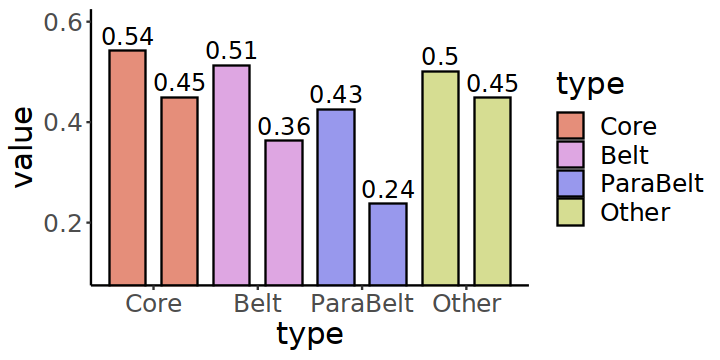

In [65]:
options(repr.plot.width=6,repr.plot.height=3)

AU_sub_Jacarrd$species <- factor(AU_sub_Jacarrd$species,levels = c('mar','mac'))
AU_sub_Jacarrd$type <- factor(AU_sub_Jacarrd$type,levels = c('Core','Belt','ParaBelt','Other'))

ggplot()+
geom_bar(data=AU_sub_Jacarrd,aes(x=type,y=value,fill=type,group=species),color='black',width=0.7,stat = 'identity',position=position_dodge(width = 1))+
geom_text(data=AU_sub_Jacarrd,aes(x=type,y=value+0.03,label=round(value,2),group=species),size=5,color='black',position=position_dodge(width = 1))+
scale_fill_manual(values = c('#E58E7A','#DEA6E2','#9898ED','#D6DD92'))+
theme_classic()+
theme(text = element_text(size=18,color='black'))+
coord_cartesian(ylim=c(0.1,0.6))

### Core region

In [81]:
DEG_hum_AU <- read_DEG('data/human_core/','hum',com_gene)
DEG_mac_AU <- read_DEG('data/mac_core/','mac',com_gene)
DEG_mar_AU <- read_DEG('data/mar_core/','mar',com_gene)

In [82]:
tmp_data_AU <- rbind(DEG_hum_AU[DEG_hum_AU$FC>2**0,],
                     DEG_mac_AU[DEG_mac_AU$FC>2**0,],
                     DEG_mar_AU[DEG_mar_AU$FC>2**0,])
tmp_data_AU$region <- gsub('Au','',tmp_data_AU$region)
tmp_data_AU$region <- gsub('AI','A1',tmp_data_AU$region)
tmp_data_AU$num <- 1
tmp_data_AU <- acast(tmp_data_AU, gene~species+region, value.var="num")
tmp_data_AU[is.na(tmp_data_AU)] = 0
AU_Jacarrd <- 1-as.matrix(proxy::dist(tmp_data_AU, by_rows = FALSE, method = "Jaccard"))


In [89]:
for (i in c(1:nrow(AU_Jacarrd))){
    AU_Jacarrd[i,i]=NA
}

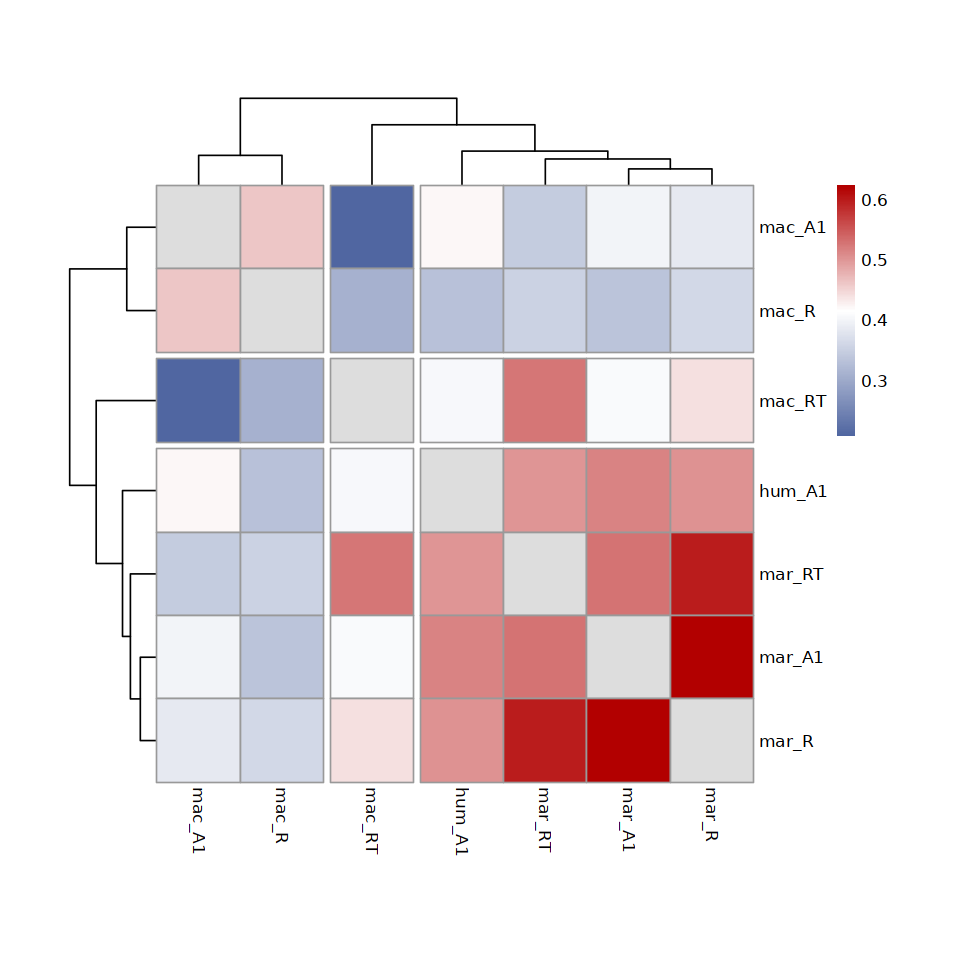

In [91]:
options(repr.plot.width=8,repr.plot.height=8) 
pheatmap(AU_Jacarrd,cluster_rows = T,cluster_cols = T,cutree_rows = 3,cutree_cols = 3,cellwidth = 50,cellheight =50,#annotation_colors = anno_colors,
         color = c(colorRampPalette(colors = c("#5066a1","white"))(100),colorRampPalette(colors = c("white","#b20000"))(100)))#,filename = '/data/work/marmoset/fig/AU/AU_three_sp.pdf')